# Behavioural Cloning Network 
##### this notebook contains code to drive a car autonomously through the Udacity Car Simulator 

In [33]:
import csv 
validation_samples = []
with open('./udacity_data/driving_log.csv') as csvfile:
    next(csvfile)
    reader = csv.reader(csvfile)
    for line in reader: 
        validation_samples.append(line)

train_samples = []
with open('./train_data/driving_log.csv') as csvfile:
    next(csvfile)
    reader = csv.reader(csvfile)
    for line in reader: 
        train_samples.append(line)        

with open('./train_data1/driving_log.csv') as csvfile:
    next(csvfile)
    reader = csv.reader(csvfile)
    for line in reader: 
        train_samples.append(line)

with open('./train_data2/driving_log.csv') as csvfile:
    next(csvfile)
    reader = csv.reader(csvfile)
    for line in reader: 
        train_samples.append(line) 

print(len(train_samples))

14882


In [37]:
#image preprocessing steps 
import cv2 
import numpy as np  
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.data_utils import Sequence
import threading
import multiprocessing 
from keras.backend import tf as ktf 
import matplotlib.pyplot as plt
%matplotlib inline


def change_brightness(image):
    # Randomly select a percent change
    change_pct = np.random.uniform(0.5, 1.2)
    
    # Change to HSV to change the brightness V
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hsv[:,:,2] = hsv[:,:,2] * change_pct
    
    #Convert back to RGB 
    #img_brightness = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    return hsv

def flip_image(image, angle):
    img_flip = cv2.flip(image,1)
    angle = -angle
    return img_flip, angle

def trans_image(image,steer,trans_range):
    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    steer_ang = steer + tr_x/trans_range*2*.2 
#    tr_y = 40*np.random.uniform()-40/2
    tr_y = 0
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])
    image_tr = cv2.warpAffine(image,Trans_M,(image.shape[1],image.shape[0]))
    
    return image_tr,steer_ang

# def visualize(samples):
#     row = 10
#     f, axarr = plt.subplots(row, 4, figsize=(15,row*4))
#     plt.figure()
#     f.subplots_adjust(hspace = .4, wspace=.001)
#     for i in range(0, len(indices)):    
#         for j in range (4):
#             randomIndex = np.random.randint(low=0, high=freq[i])
#             subtitle = "Class:" + str(y_test[indices[i] + randomIndex])
#             axarr[i,j].set_title(subtitle, fontsize=14)
#             axarr[i,j].set_aspect(aspect=1, adjustable='box')
#             axarr[i,j].imshow(np.round(X_test[indices[i] + randomIndex]).astype(np.uint8))
    

def preprocess_image(image, angle): 
    image = change_brightness(image)
    image, angle = trans_image(image,angle,50)
    if np.random.randint(2) == 1:
        image, angle = flip_image(image, angle)
    return image, angle

class TrainingSequence(Sequence):
    def __init__(self, x_set, y_set, dirs, batch_size):
        self.X,self.y = x_set,y_set
        self.batch_size = batch_size
        self.dirs = dirs
        
    def __len__(self):
        return len(self.X) 

    def __getitem__(self,idx):
        #print ("Process: " + multiprocessing.current_process().name + "idx is " + str(idx))
        idx %= ((len(self.X) / self.batch_size))
        idx = int(idx)
        batch_samples = self.X[idx*self.batch_size:(idx+1)*self.batch_size]    
        images = []
        angles = []
        drop_prob = 0.5
        for batch_sample in batch_samples:
            index = 0 
            rand_i = np.random.randint(low=0,high=2)
            #print(batch_sample[rand_i].split('/')[-1])
            path = './'+ self.dirs[index] + '/IMG/'+batch_sample[rand_i].split('/')[-1]                 
            image = cv2.imread(path)
            while image is None: 
                index += 1
                path = './'+ self.dirs[index] +'/IMG/'+batch_sample[rand_i].split('/')[-1] 
                image = cv2.imread(path)
            angle = float(batch_sample[3])
            if rand_i == 1: 
                angle += 0.25 
            elif rand_i == 2: 
                angle -= 0.25
                
            keep = 0
            while keep == 0:
                image, angle = preprocess_image(image, angle)
                if abs(angle) < 0.18:
                    if np.random.sample() > drop_prob: 
                        keep = 1
                else:
                    keep = 1
            images.append(image)
            angles.append(angle)
        X_train = np.array(images)
        y_train = np.array(angles)
        return X_train, y_train

class ValidationSequence(Sequence):
    def __init__(self, x_set, y_set, dirs, batch_size):
        self.X,self.y = x_set,y_set
        self.batch_size = batch_size
        self.dirs = dirs
        
    def __len__(self):
        return len(self.X) 

    def __getitem__(self,idx):
        #print ("Process: " + multiprocessing.current_process().name + "idx is " + str(idx))
        idx %= ((len(self.X) / self.batch_size))
        idx = int(idx)
        batch_samples = self.X[idx*self.batch_size:(idx+1)*self.batch_size]    
        images = []
        angles = []
        for batch_sample in batch_samples:
            index = 0 
            rand_i = np.random.randint(low=0,high=3)
            #print(batch_sample[rand_i].split('/')[-1])
            path = './'+ self.dirs[index] + '/IMG/'+batch_sample[rand_i].split('/')[-1]                 
            image = cv2.imread(path)
            while image is None: 
                index += 1
                path = './'+ self.dirs[index] +'/IMG/'+batch_sample[rand_i].split('/')[-1] 
                image = cv2.imread(path)
            angle = float(batch_sample[3])
#             if rand_i == 1: 
#                 angle += 0.25 
#             elif rand_i == 2: 
#                 angle -= 0.25
            
            #image, angle = preprocess_image(image, angle)
            images.append(image)
            angles.append(angle)
        X_train = np.array(images)
        y_train = np.array(angles)
        return X_train, y_train

def make_histogram(sequence):
    bins = np.arange(-1,1, 0.05)  
    x_data = [] 
    y_data = []
    for i in range(int(sequence.__len__() / 256)):
        x_batch, y_batch = sequence.__getitem__(i)
        x_data.append(x_batch)
        y_data.append(y_batch)
    
    fig, ax = plt.subplots(ncols=1, figsize=(20, 10), linewidth=1)
    # Create a histogram by providing the bin edges (unequally spaced).
    ax.hist(y_data, bins, histtype='stepfilled', facecolor='y')
    ax.set_title('Validation Set Distribution')  
    fig.tight_layout()
    plt.show()

def display_images(sequence , num_to_display): 
    plt.rcParams["figure.figsize"] = [20, num_to_display]
    batch_x, batch_y = sequence.__getitem__(1)
    for i in range(0, num_to_display):
        print(batch_x[i].shape)
        plt.subplot(4, 5, i+1) 
        plt.tight_layout()
        plt.axis('off')
        plt.title(str(np.round(batch_y[i],5)), fontsize=30)
        plt.imshow(batch_x[i][60:130,:]) 

In [38]:
from keras.models import Sequential 
from keras.layers import Flatten, Dense, Lambda, Conv2D, Dropout
from keras.backend import tf as ktf 

def resize_normalize(image):
    import cv2
    from keras.backend import tf as ktf   
    
    # resize to width 200 and high 66 liek recommended
    # in the nvidia paper for the used CNN
    # image = cv2.resize(image, (66, 200)) #first try
    image = ktf.image.crop_to_bounding_box(image, 60, 0, 70, 320)
    resized = ktf.image.resize_images(image, (66, 200))
    #normalize 0-1
    resized = resized/255.0 - 0.5

    return resized

#resizing & normalization lambda layers
resize_normalize = Lambda(resize_normalize, input_shape=(None, 320, 3))

model = Sequential() 

model.add(resize_normalize)

# input: 3@66x200 conv ouput: 24@31x98
model.add(Conv2D(24, kernel_size=(5,5), strides=(2, 2), padding='valid', activation='elu', kernel_initializer='he_normal', bias_initializer='zeros'))
model.add(Dropout(0.2))
# conv output: 36@14x47
model.add(Conv2D(36, kernel_size=(5,5), strides=(2, 2), padding='valid', activation='elu', kernel_initializer='he_normal', bias_initializer='zeros'))          
model.add(Dropout(0.2))
# conv output: 48@5x22
model.add(Conv2D(48, kernel_size=(5,5), strides=(2, 2), padding='valid', activation='elu', kernel_initializer='he_normal', bias_initializer='zeros'))    

model.add(Dropout(0.2))
# conv output: 64@3x20
model.add(Conv2D(64, kernel_size=(3,3), strides=(1, 1), padding='valid', activation='elu', kernel_initializer='he_normal', bias_initializer='zeros')) 
model.add(Dropout(0.2))

# conv output: 64@1x18 
model.add(Conv2D(64, kernel_size=(3,3), strides=(1, 1), padding='valid', activation='elu', kernel_initializer='he_normal', bias_initializer='zeros')) 
model.add(Dropout(0.2))

# Fully connected layers
model.add(Flatten())
model.add(Dense(100, kernel_initializer='he_normal', bias_initializer='zeros', activation='elu'))
model.add(Dropout(0.2))
model.add(Dense(50, kernel_initializer='he_normal', bias_initializer='zeros', activation='elu')) 
model.add(Dropout(0.2))
model.add(Dense(10, kernel_initializer='he_normal', bias_initializer='zeros', activation='elu'))
model.add(Dropout(0.2))
model.add(Dense(1, kernel_initializer='he_normal', bias_initializer='zeros'))

model.compile(loss='mse', optimizer='adam')
print()
    

2.0.6
32
59
(160, 320, 3)
(160, 320, 3)
(160, 320, 3)
(160, 320, 3)
(160, 320, 3)
(160, 320, 3)
(160, 320, 3)
(160, 320, 3)
(160, 320, 3)
(160, 320, 3)
Epoch 1/30
59/58 [==============================] - 28s - loss: 0.3306 - val_loss: 0.0282
Epoch 2/30
59/58 [==============================] - 27s - loss: 0.1140 - val_loss: 0.0237
Epoch 3/30
59/58 [==============================] - 27s - loss: 0.0687 - val_loss: 0.0249
Epoch 4/30
59/58 [==============================] - 26s - loss: 0.0506 - val_loss: 0.0244
Epoch 5/30
59/58 [==============================] - 27s - loss: 0.0437 - val_loss: 0.0247
Epoch 6/30
59/58 [==============================] - 27s - loss: 0.0384 - val_loss: 0.0259


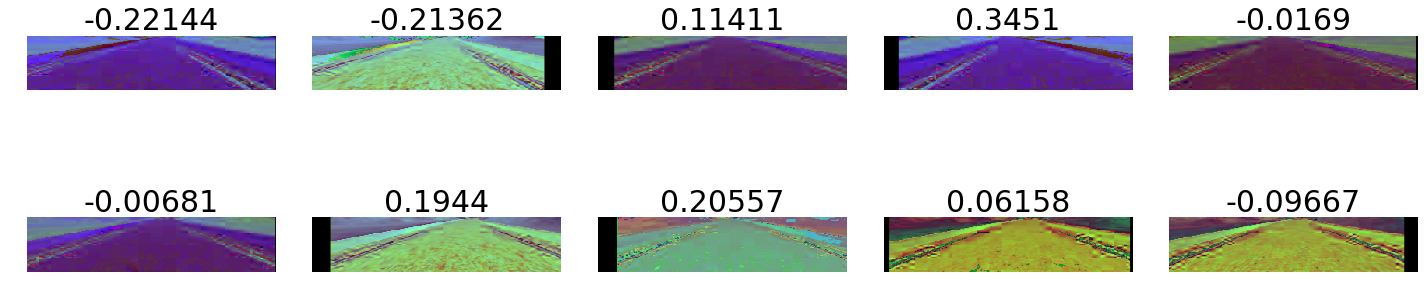

In [39]:
import keras
from keras.callbacks import EarlyStopping
import math
print(keras.__version__)
batch_size = 256

#model.fit(X_val, y_val, validation_split=0.2, shuffle=True, nb_epoch=7)
#model.fit(X_data, y_data, batch_size=256, shuffle=True, epochs=25, validation_data=(X_val, y_val))
# compile and train the model using the generator function
print(math.ceil(len(validation_samples)/batch_size))
print(math.ceil(len(train_samples)/batch_size))
train_generator = TrainingSequence(train_samples,None, ['train_data', 'train_data1', 'train_data2'], batch_size=batch_size)
validation_generator = ValidationSequence(validation_samples,None, ['udacity_data'], batch_size=batch_size)
#make_histogram(train_generator)
display_images(train_generator, 10)
earlyStopping=keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=0, mode='min')
#make_histogram(validation_generator)
history_object = model.fit_generator(train_generator, validation_data=validation_generator, validation_steps=len(validation_samples)/batch_size , epochs=30, steps_per_epoch=len(train_samples)/batch_size , workers=4, use_multiprocessing=True, max_queue_size=2 , callbacks=[earlyStopping])
model.save('model.h5')

#./udacity_data/IMG/center_2016_12_01_13_30_48_287.jpg

dict_keys(['val_loss', 'loss'])


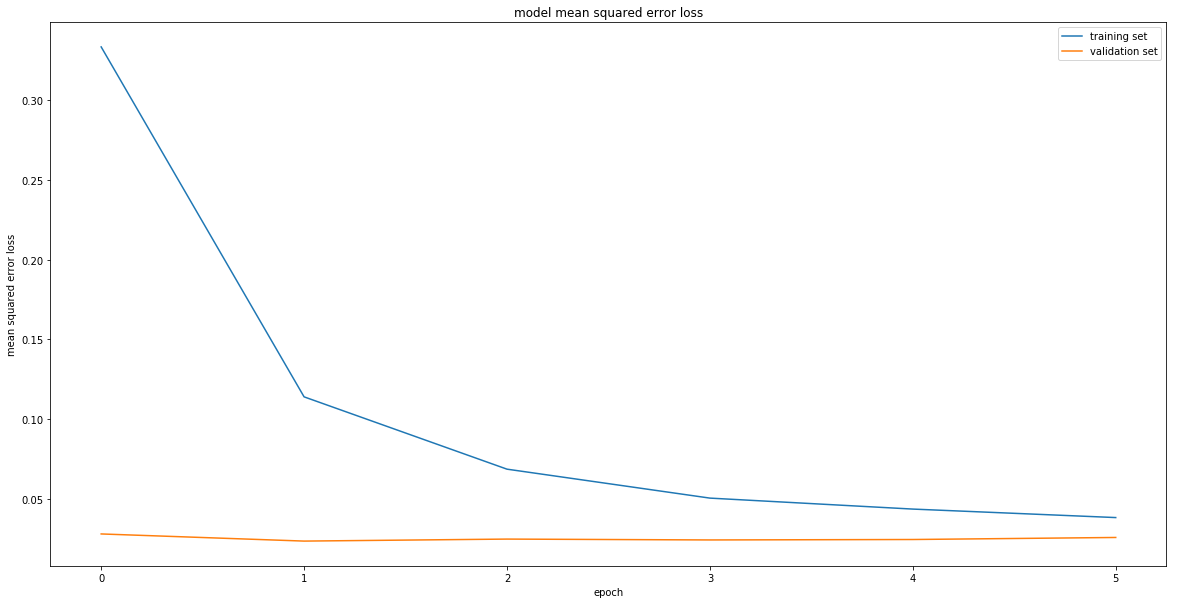

In [40]:
from keras.models import Model

print(history_object.history.keys())


plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()